In [ ]:
!jar xvf test.zip

In [4]:
!unzip test.zip

Archive:  test.zip
replace test/artifact/1-103999-A-30.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test/artifact/1-103999-A-30.wav  
replace test/artifact/1-15689-A-4.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace test/artifact/1-15689-A-4.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test/artifact/1-15689-A-4.wav  
  inflating: test/artifact/1-181071-A-40.wav  
  inflating: test/artifact/1-18527-A-44.wav  
  inflating: test/artifact/1-19501-A-7.wav  
  inflating: test/artifact/1-196660-A-8.wav  
  inflating: test/artifact/1-19840-A-36.wav  
  inflating: test/artifact/1-20736-A-18.wav  
  inflating: test/artifact/1-22694-A-20.wav  
  inflating: test/artifact/1-23706-A-49.wav  
  inflating: test/artifact/1-30214-A-18.wav  
  inflating: test/artifact/1-34094-B-5.wav  
  inflating: test/artifact/1-35687-A-38.wav  
  inflating: test/artifact/1-40967-A-28.wav  
  inflating: test/artifact/1-43760-A-11.wav  
  inflating: test/artifa

In [1]:
!pip install transformers[torch] torchmetrics datasets evaluate torch_audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00

In [ ]:
# Data preprocessing

In [71]:
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize

import torch
import torchmetrics
from torch.utils.data import DataLoader
from torch import nn

from datasets import load_dataset, load_from_disk, Audio, Dataset
from transformers import ASTForAudioClassification, ASTFeatureExtractor
from transformers import AutoModelForAudioClassification, Trainer, TrainingArguments

import evaluate

import wandb

device = "cuda" if torch.cuda.is_available() else "cpu"

In [91]:
dataset_test = load_dataset("audiofolder", "test")

Resolving data files:   0%|          | 0/656 [00:00<?, ?it/s]

In [92]:
labels = ['artifact', 'healthy', 'unhealthy']

label2id = {label: labels.index(label) for label in labels}
id2label = {str(id): label for label, id in label2id.items()}

In [93]:
model_checkpoint = "Vladimirlv/ast-finetuned-audioset-10-10-0.4593-heart-sounds"

In [94]:
TIME_LIMIT_SECONDS = 10
SAMPLE_RATE = 16000
target_length = SAMPLE_RATE * TIME_LIMIT_SECONDS
extractor = ASTFeatureExtractor.from_pretrained(
    model_checkpoint,
    do_normalize=True
)

In [95]:
def preprocess(dataset, extractor=extractor, batch_size=10, num_proc=1, target_length=target_length):
    # Ensure the audio is loaded with the correct sampling rate
    dataset = dataset.cast_column("audio", Audio(sampling_rate=extractor.sampling_rate))

    def preprocess_function(examples):
        audio_arrays = []
        new_labels = []
        for audio, label in zip(examples["audio"], examples["label"]):
            arr = audio["array"]
            # Ensure each audio sample is exactly 10 seconds long
            if len(arr) < target_length:
                arr = np.pad(arr, (0, target_length - len(arr)), mode='constant')
            else:
                arr = arr[:target_length]
            audio_arrays.append(arr)
            new_labels.append(label)  # Assuming label is already numeric

        # Use the feature extractor without additional truncation or max_length adjustments.
        inputs = extractor(
            audio_arrays,
            sampling_rate=SAMPLE_RATE,
            truncation=False  # Not needed since we've fixed the length manually
            # Optionally add padding="longest" if required by your model architecture
        )
        # Explicitly convert labels to torch.long
        inputs["labels"] = torch.tensor(new_labels, dtype=torch.long)
        return inputs

    dataset = dataset.map(
        preprocess_function,
        batched=True,
        batch_size=batch_size,
        num_proc=num_proc,
        remove_columns=["audio"]
    )

    return dataset

In [96]:
dataset_test = preprocess(dataset_test)

In [97]:
dataset_test = dataset_test["test"]

Available keys in the sample: dict_keys(['label', 'input_values', 'labels'])


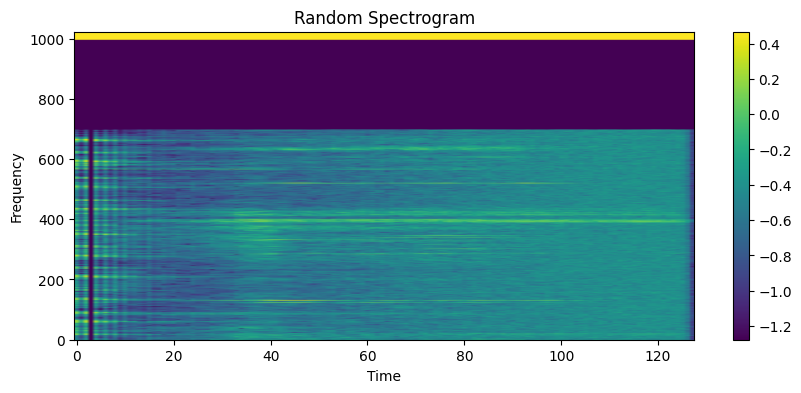

In [38]:
import random
import matplotlib.pyplot as plt
import numpy as np

idx = random.randint(0, len(dataset_test) - 1)
sample = dataset_test[idx]

# Print the keys to inspect the available data
print("Available keys in the sample:", sample.keys())

# Assuming the spectrogram is stored under 'input_values'
spectrogram = np.array(sample["input_values"])

# If the spectrogram has an extra channel dimension (e.g., shape (1, H, W)), remove it:
if spectrogram.ndim == 3 and spectrogram.shape[0] == 1:
    spectrogram = np.squeeze(spectrogram, axis=0)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, origin="lower", aspect="auto")
plt.title("Random Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [98]:
model = AutoModelForAudioClassification.from_pretrained("Vladimirlv/ast-finetuned-audioset-10-10-0.4593-heart-sounds")

In [ ]:
# Evaluate metrics

In [99]:
model.eval()

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       

In [ ]:
## Accuracy, Precision, Recall, Confusion Matrix

In [61]:
def get_prediction(example):
    # Convert the list/array to a tensor and add a batch dimension.
    input_tensor = torch.tensor(example["input_values"]).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_tensor)
    # Get predicted class index by taking the argmax over the logits.
    pred = torch.argmax(outputs.logits, dim=-1).item()
    return pred


dataset_test = dataset_test.map(lambda x: {"pred": get_prediction(x)})

Map:   0%|          | 0/656 [00:00<?, ? examples/s]

Overall Metrics:
Accuracy: 0.9527439024390244
Precision per class: [1.         0.9481268  0.87619048]
Recall per class: [1.         0.9619883  0.83636364]


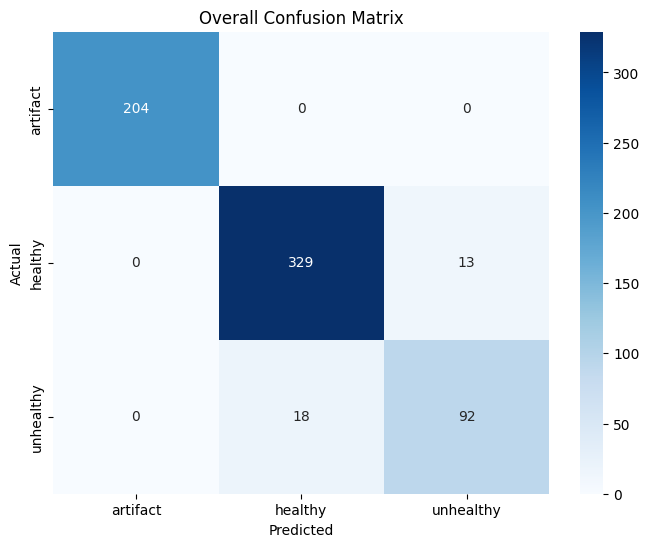

In [63]:
y_true = np.array(dataset_test["label"])
y_pred = np.array(dataset_test["pred"])

accuracy_overall = accuracy_score(y_true, y_pred)
conf_matrix_overall = confusion_matrix(y_true, y_pred)
precision_overall = precision_score(y_true, y_pred, average=None)
recall_overall = recall_score(y_true, y_pred, average=None)

print("Overall Metrics:")
print("Accuracy:", accuracy_overall)
print("Precision per class:", precision_overall)
print("Recall per class:", recall_overall)


# Plot overall confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_overall, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Overall Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Binary Metrics (Healthy vs. Unhealthy):
Accuracy: 0.9314159292035398
Precision: 0.8761904761904762
Recall: 0.8363636363636363


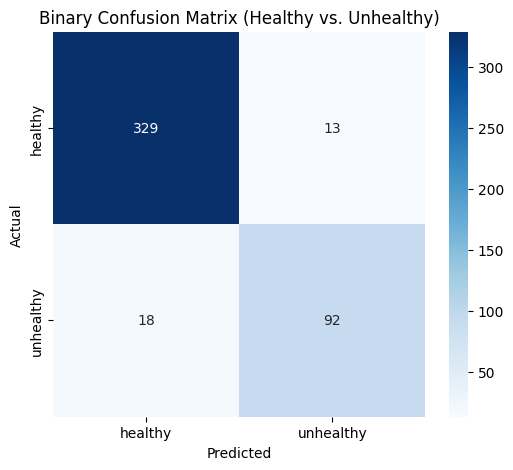

In [67]:
binary_mask = y_true != 0
y_true_binary = y_true[binary_mask]
y_pred_binary = y_pred[binary_mask]


y_true_binary_remap = y_true_binary - 1
y_pred_binary_remap = y_pred_binary - 1

accuracy_binary = accuracy_score(y_true_binary_remap, y_pred_binary_remap)
conf_matrix_binary = confusion_matrix(y_true_binary_remap, y_pred_binary_remap)
precision_binary = precision_score(y_true_binary_remap, y_pred_binary_remap)
recall_binary = recall_score(y_true_binary_remap, y_pred_binary_remap)

print("Binary Metrics (Healthy vs. Unhealthy):")
print("Accuracy:", accuracy_binary)
print("Precision:", precision_binary)
print("Recall:", recall_binary)

# Define class names for binary metrics
class_names_binary = ['healthy', 'unhealthy']

# Plot binary confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_binary, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names_binary, yticklabels=class_names_binary)
plt.title("Binary Confusion Matrix (Healthy vs. Unhealthy)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## pr auc and roc auc with probabilities (overconfident)

In [ ]:
def get_probabilities(example):
    # Convert input_values to a tensor, add batch dimension, and compute softmax probabilities.
    input_tensor = torch.tensor(example["input_values"]).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_tensor)
    probs = torch.softmax(outputs.logits, dim=-1).squeeze(0).numpy()
    return probs

# Add a new field 'probs' to each example
dataset_test = dataset_test.map(lambda x: {"probs": get_probabilities(x)})

# Stack probabilities into a numpy array: shape (num_samples, num_classes)
y_probs = np.stack(dataset_test["probs"])

Map:   0%|          | 0/656 [00:00<?, ? examples/s]

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("deep")

y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
n_classes = y_probs.shape[1]

plt.figure(figsize=(15, 8))
for i in range(n_classes):
    # Compute Precision-Recall curve.
    precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
    # Compute ROC curve.
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc_val = auc(fpr, tpr)

    # Plot Precision-Recall curve for class i.
    plt.subplot(2, n_classes, i + 1)
    plt.plot(recall_curve, precision_curve, label=f'PR AUC={auc(recall_curve, precision_curve):.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR Curve for Class {i}')
    plt.legend()

    # Plot ROC curve for class i.
    plt.subplot(2, n_classes, n_classes + i + 1)
    plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc_val:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {i}')
    plt.legend()

plt.tight_layout()
plt.show()